# New York and San Francisco housing attributes dataset

There exists a [small dataset](./ny_sf_apt.csv) on housing attributes in New York and San Francisco. We're going to look at this dataset in the context of logistic regression.

## Overview of our problem

#### Goals:
* To classify houses as being in NY or SF (i.e. binary classification)
* Understand how logistic regression works

#### What logistic regression gives us:
* A probability of a house being in SF or NY. This is called a _soft classification_.
* A classification of whether or not a house is in NY or SF by setting a cutoff on the probability. By default, this cutoff is the highest probability outcome (i.e. the class that has probabiltiy > 50%). This is called a _hard classification_.
* Coefficients, which we can use to help us interpret which features are most important to the classification (provided we have scaled them first)

#### Initial approach:
* Use one feature to make prediction (to help understand LR)
* Use two features and find decision surfaces
* Use all the features (at the expense of visualization)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler


Now import the (pre-cleaned) dataset:

In [2]:
df_housing = pd.read_csv('./ny_sf_apt.csv')
df_housing.head()

,in_sf,beds,bath,price,year_built,sqft,price_per_sqft,elevation
0,0,2.0,1.0,999000,1960,1000,999,10
1,0,2.0,2.0,2750000,2006,1418,1939,0
2,0,2.0,2.0,1350000,1900,2150,628,9
3,0,1.0,1.0,629000,1903,500,1258,9
4,0,0.0,1.0,439000,1930,500,878,10


Our goal is to predict whether or not the house is `in_sf` or not (if it is not in SF, it is in NY). Before going any further, let's do our test-train split:

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df_housing.iloc[:, 1:], df_housing.iloc[:, 0], 
                                                    test_size = 0.2, random_state=42)

In [4]:
# Ok, which feature looks promising? We'll restrict ourselves to one for now
train_df = X_train.copy()
train_df['in_sf'] = y_train

train_df['location'] = train_df['in_sf'].apply(lambda x: (x and 'SF') or 'NY')
train_df.head()

,beds,bath,price,year_built,sqft,price_per_sqft,elevation,in_sf,location
377,3.0,2.0,2395000,1929,2323,1031,73,1,SF
124,0.0,1.0,349000,1960,400,873,13,0,NY
419,4.0,3.0,3420000,1926,5113,669,98,1,SF
417,6.0,3.5,995000,2001,3080,323,55,1,SF
172,2.0,2.0,1599000,1973,1400,1142,10,0,NY


C:\Users\chris\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\chris\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


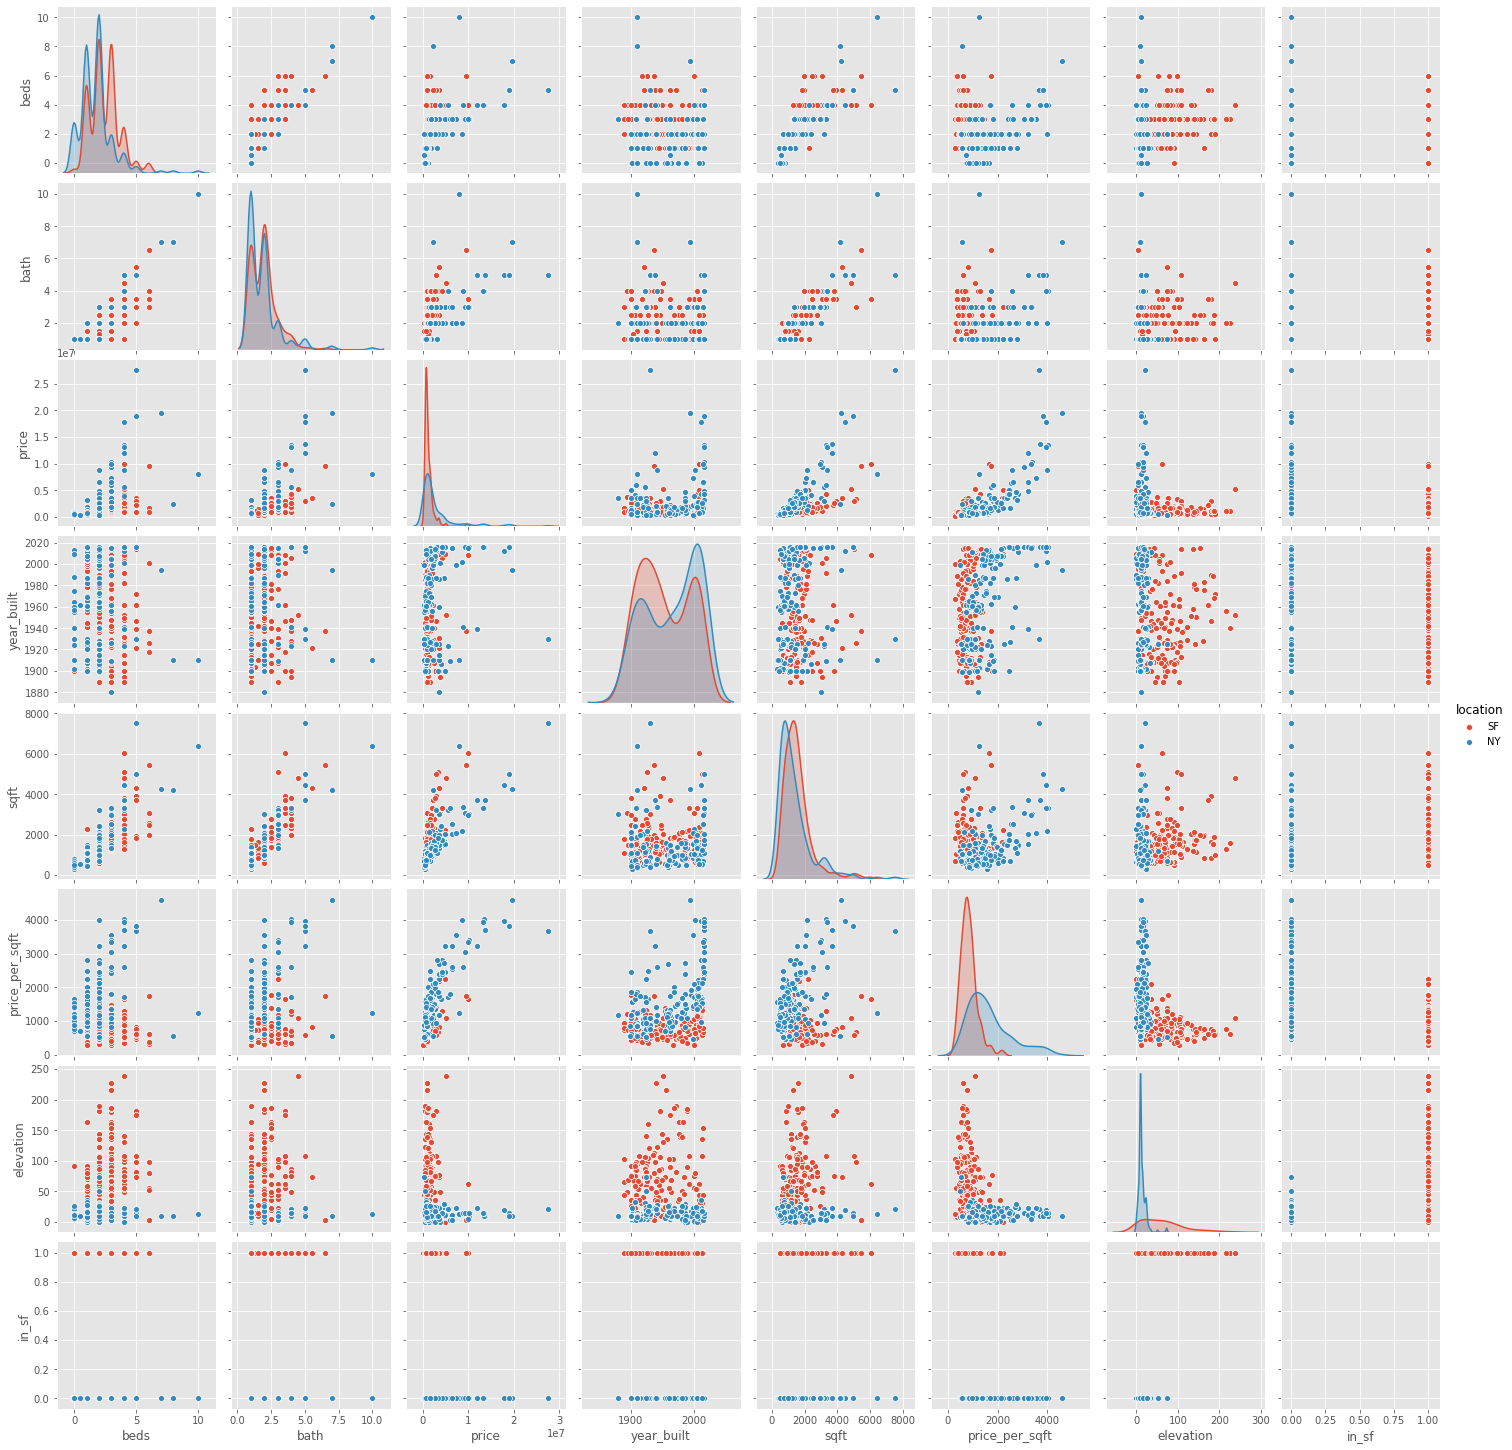

In [5]:
# We want to pick one feature to start that separates the two cases. 
# Look down the diagonal to find a covariate that separates the data well 

sns.pairplot(train_df, hue='location');

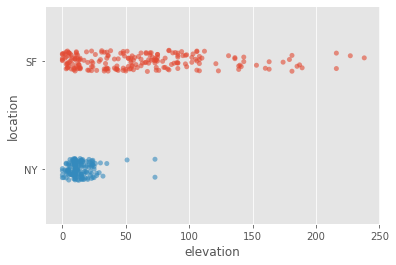

In [6]:
sns.stripplot(x='elevation',y='location', jitter=True,data=train_df,alpha=0.6);

## Enter logistic regression

Because there is only one feature (elevation) that we are looking at right now, applying the standard scaler is superflous. To keep our results interpretable, we will stay with the unscaled elevation as a feature.

In [7]:
lm1 = LogisticRegression(solver= 'liblinear', C=1000)
lm1.fit(X_train[['elevation']], y_train)


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
lm1.score(X_train[['elevation']], y_train)

0.8040712468193384

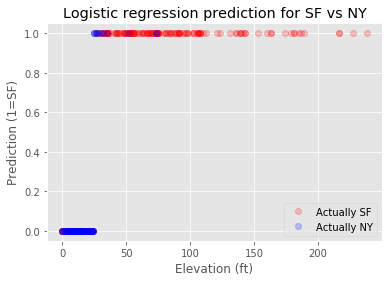

In [9]:
# Let's look at what lm1 did
feature = train_df[['elevation']].values
prediction_hard = lm1.predict(feature)

sf_mask = (train_df['location'] == 'SF').values

plt.plot(feature[sf_mask], prediction_hard[sf_mask], 'ro', label='Actually SF', alpha=0.2)
plt.plot(feature[~sf_mask], prediction_hard[~sf_mask], 'bo', label='Actually NY', alpha=0.2)
plt.ylim(-0.05, 1.05)
plt.xlabel('Elevation (ft)')
plt.ylabel('Prediction (1=SF)')
plt.title('Logistic regression prediction for SF vs NY')
plt.legend(loc='lower right');

The logistic regression has basically made a hard cutoff around 25 ft: lower than that, the prediction is you are in NY. Higher than that, the model predicts you are in SF. This is called a _hard cutoff_. 

Under the hood, logistic regression produces probabilities, and chooses the most likely one as the prediction. We can also look at the model's probability of assigning a point to SF:

In [10]:
# choose different values of elevation; output is their probability of being in SF
lm1.predict_proba([[73],[23],[25]])[:,1]

array([0.96445639, 0.48096024, 0.51471678])

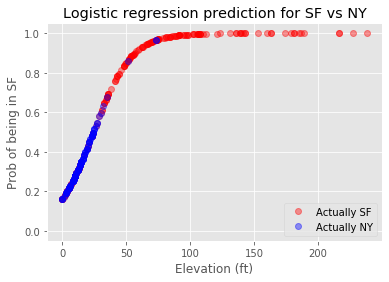

In [11]:
# This is the same model but with proba (returns probabilities instead of class)
prediction_soft = lm1.predict_proba(feature)[:, 1]

plt.plot(feature[sf_mask], prediction_soft[sf_mask], 'ro', label='Actually SF',alpha=0.4)
plt.plot(feature[~sf_mask], prediction_soft[~sf_mask], 'bo', label='Actually NY',alpha=0.4)
plt.ylim(-0.05, 1.05)
plt.xlabel('Elevation (ft)')
plt.ylabel('Prob of being in SF')
plt.title('Logistic regression prediction for SF vs NY')
plt.legend(loc='lower right');

This is called a _soft classification_, because we don't just get access to what the model is thinks is the most likely outcome, but we also get to know how likely it thinks the prediction is.

In [12]:
# Look at the coefficient and intercept of the model:
lm1.coef_, lm1.intercept_

(array([[0.06754]]), array([-1.62961593]))

The 50% probability is reached when $\beta \cdot \vec{x} = 0$, i.e. when $\beta_1 x_1 + \beta_0 1 = 0$, or when the odds equal 1, so the log odds = 0. Solving this, we have
$$0.06754*elevation_{crit} - 1.62961593 = 0 \Rightarrow elevation_{crit} = \frac{1.62961593}{0.06754} \approx 24.1$$
i.e. the actual cutoff is 24.1 ft, which is close to the 25 ft we guessed by reading the graph. 

In [13]:
# what do our coefficients mean?

np.exp(lm1.coef_)

array([[1.06987306]])

The exponentiated coefficient represents the odds ratio for a 1 unit increase in elevation. That is to say, a house at 20 feet will have 1.07 times the odds of being in SF as a house that is 19 feet in elevation. 

## Error type

What types of errors is this model making? From the graph, it looks like we are getting almost all the SF apartments right, and that our errors are coming from classifying some NY houses as SF houses. We are going to use the hard predictions to check with `confusion_matrix`

In [14]:
confusion_matrix(y_train, prediction_hard)

array([[168,  13],
       [ 64, 148]], dtype=int64)

i.e. we get 

| | predict NY (0) | predict SF (1)|
|---|---|---|
| **is NY (0)** | 168 | 13|
| **is SF (1)** | 64 | 148 |

i.e. my impression from the graph is **wrong** -- the overlay of points obscures the fact we only made 13 mistakes with NY apartments, but made 64 mistakes with SF apartments. We plotted SF first, so NY can cover SF. Still, we should check and make sure we understand this:

In [13]:
# Out of those in SF, how many were predicted to be NY?
sum(prediction_hard[sf_mask] == 0)

64

Our plotting order mattered and mislead us (or at least, mislead me!)

### Cheating

For the purposes of demonstration, what would happen if we 

- throw out all SF apartments that have elevations less than 24 ft AND
- throw out all NY apartments that have elevations greater than 24 ft

from our training set? This shouldn't change the decision point much .... so what will it change?

In [14]:
# This is to explore a model
# This is NOT legitimate data science!
keep_sf_mask = ((train_df['location'] == 'SF') & (train_df['elevation'] > 24))
keep_ny_mask = ((train_df['location'] == 'NY') & (train_df['elevation'] < 24))
cheat_df = train_df[keep_sf_mask | keep_ny_mask]

In [15]:
lm2 = LogisticRegression(solver='liblinear')
lm2.fit(cheat_df[['elevation']], cheat_df['in_sf'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

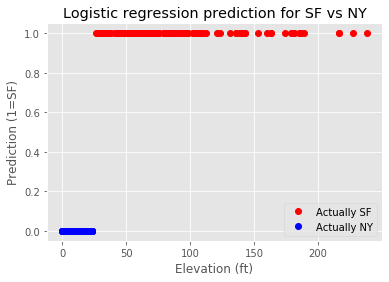

In [16]:
# Plot the 'hard' classifier. What do we expect to happen?
feature = cheat_df[['elevation']].values
prediction_hard = lm1.predict(feature)

sf_mask = (cheat_df['location'] == 'SF').values

plt.plot(feature[sf_mask], prediction_hard[sf_mask], 'ro', label='Actually SF')
plt.plot(feature[~sf_mask], prediction_hard[~sf_mask], 'bo', label='Actually NY')
plt.ylim(-0.05, 1.05)
plt.xlabel('Elevation (ft)')
plt.ylabel('Prediction (1=SF)')
plt.title('Logistic regression prediction for SF vs NY')
plt.legend(loc='lower right');

In [17]:
# Look at the coefficients:
lm2.coef_, lm2.intercept_

(array([[0.19735996]]), array([-5.30717257]))

In [22]:
# Try yourself - interpret the coefficient for elevation

Even though the decision point stayed close to the same, the coefficients and the intercept changed drastically! We still have
$$elevation_{crit} = \frac{5.30717257}{0.19735996} \approx 26.9$$

The difference is hard to see in the hard classification, but easy to spot in the simple classifier:

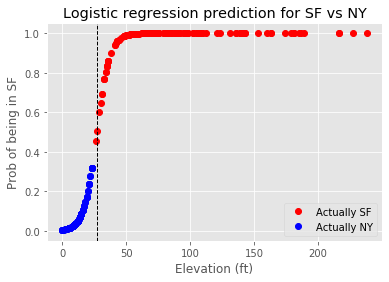

In [19]:
# This is the same model
prediction_soft = lm2.predict_proba(feature)[:, 1]

plt.plot(feature[sf_mask], prediction_soft[sf_mask], 'ro', label='Actually SF')
plt.plot(feature[~sf_mask], prediction_soft[~sf_mask], 'bo', label='Actually NY')
plt.ylim(-0.05, 1.05)
plt.xlabel('Elevation (ft)')
plt.ylabel('Prob of being in SF')
plt.title('Logistic regression prediction for SF vs NY')
plt.gca().axvline(26.9,c='k',ls='--',lw=1)
plt.legend(loc='lower right');

Even though the decision point didn't move very much, the model got a lot more certain about the predictions it did make! 

**Logistic regression doesn't maximize accuracy**

Instead, logistic regression has a cost function (in the binary classification problem) of
$$J_{\text{model}}(\beta) = -\frac{1}{m}\left(\sum_{i=1}^m y_i \ln p_i + (1-y_i) \ln (1-p_i)\right), \quad\quad p_i\text{ function of $\beta$}$$

This is called the cross-entropy. Here $y_i \in \{0,1\}$, so we can tell:
* when $y_i = 1$ (i.e. the house is actually in SF), the contribution is $-\ln p_i$. The closer $p_i$ is to 1, the smaller the cost. If $p_i = 0$ (that is, we claimed it was impossible for this house to be in SF) then we incur an infinite penalty.
* when $y_i = 0$ (i.e. the house is actually in NY), the contribution is $-\ln(1-p_i)$. The closer $p_i$ is to 0, the smaller the penalty. If we claimed $p_i = 1$ (i.e. this house in NY *must* be in SF) then we incur an infinite penalty.

The effect is that we are trying to get the model to optimize the probabilities by giving small cost to those it gets right with high confidence, a medium cost to those it waffles on (i.e. doesn't commit one way or the other), and a high cost to those that it predicts with high confidence but gets wrong.

## That C parameter

In linear regression, we had a $\lambda$ parameter that controlled regularization:
$$J_{\text{linear}} = J_{\text{model}} + J_{\text{regularization}}, \quad\quad\quad J_{\text{regularization}} = \lambda \sum_{i\neq 0} |\beta_i|^q$$
where $q = 1$ is LASSO and $q=2$ is Ridge. If $\lambda = 0$, we were turning off regularization. The model cost was generally MAE or MSE.


In logistic regression, we have a $C$ parameter that controls regularization. We have
$$J_{\text{logistic}} = C J_{\text{model}} + J_{\text{regularization}}, \quad\quad\quad J_{\text{regularization}} = \frac{1}{2}\sum_{i\neq 0} |\beta_i|^2 \text{ or } \sum_{i\neq 0} |\beta_i| $$
i.e. the regularization term is always present, and setting $C=0$ turns the model part off (i.e. it doesn't matter how much you miss the points by). So for logistic regression, high C means "lots of model importance, so regularization's effect is small" whereas low C means "model importance is small, so regularization effect is large". 

I don't know why it is done this way!

In [18]:
## Student exercise
# (1) Using train_df, make a model using only the covariate price_per_sqft


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
# (2) What's the model accuracy? Generate a percentage estimate and a confusion matrix



0.7760814249363868

In [21]:
# (3) Create a mask as above and plot the hard predictions for your new model


## Using two features

Let's combine `price_per_sqft` and `elevation`

In [24]:
std_scale = StandardScaler()

X_train = train_df[['elevation', 'price_per_sqft']]
#X_train_scaled = std_scale.fit_transform(X_train)

lm3 = LogisticRegression(solver='liblinear', C=1000)
lm3.fit(X_train, y_train)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
y_predict = lm3.predict(X_train)  # This is a hard classifier
lm3.score(X_train, y_train)

0.821882951653944

In [31]:
price = (X_train[['elevation', 'price_per_sqft']])
predictions = lm3.predict(price)
confusion_matrix(y_train, predictions)

array([[156,  25],
       [ 45, 167]], dtype=int64)